In [58]:
%matplotlib inline

In [59]:
import random

In [60]:
class BayesModel:

    """Bayesian belief network model with boolean variables."""

    def __init__(self, node_specs=[]):
        
        self.nodes = []
        self.variables = []
        for node_spec in node_specs:
            self.add(node_spec)

    def add(self, node_spec):
        """Parent nodes should be added first."""
        
        node = Node(*node_spec)

        assert node.variable not in self.variables
        assert all((parent in self.variables) for parent in node.parents)
        self.nodes.append(node)
        self.variables.append(node.variable)
        for parent in node.parents:
            self.variable_node(parent).children.append(node)

    def variable_node(self, var):
        for n in self.nodes:
            if n.variable == var:
                return n

    def variable_values(self, var):
        return [True, False]

    def __repr__(self):
        return 'BayesModel(%r)' % self.nodes

In [61]:
class Node:

    """Takes conditional probability distribution of variables in the network."""

    def __init__(self, X, parents, cpt):
        """
        inputs:
            X       : variable name
            parents : string of variable names separated by space e.g. 'P Q', parent variables P and Q
            cpt     : dictinary of the probabilities for booleans
            example : Node('Z', 'X Y',{(T, T): 0.7, (T, F): 0.1, (F, T): 0.2, (F, F): 0.3})
            
        """
        if isinstance(parents, str):
            parents = parents.split()      #takes second string (the parents), split the variables 
            
        if isinstance(cpt, (float, int)):  # no parents
            cpt = {(): cpt}

        elif isinstance(cpt, dict):        # one parent
            if cpt and isinstance(list(cpt.keys())[0], bool):
                cpt = {(v,): p for v, p in cpt.items()}

        assert isinstance(cpt, dict)
        for vs, p in cpt.items():
            assert isinstance(vs, tuple) and len(vs) == len(parents)
            assert all(isinstance(v, bool) for v in vs)
            assert 0 <= p <= 1

        self.variable = X
        self.parents = parents
        self.cpt = cpt
        self.children = []
        

    def p(self, value, event):
        """Returns conditional probability.
           e.g. P(X| parents=parent_values)
                p(True, {'X': True, 'Y': True}
        
        """
        assert isinstance(value, bool)
        ptrue = self.cpt[event_values(event, self.parents)]
        
        return ptrue if value else 1 - ptrue

    
    def __repr__(self):
        return repr((self.variable, ' '.join(self.parents)))


In [62]:
class Distribution:

    """
    Probability Distribution
    Example: p = Distribution('X', {'a': 2, 'b': 4})
             p['a'],p['b'] returns (2,4) 
    """

    def __init__(self, varname='?', freqs=None):
        """If freqs is given, it is a dictionary of value: frequency pairs,
        and the Distribution then is normalized."""
        self.prob = {}
        self.varname = varname
        self.values = []
        if freqs:
            for (v, p) in freqs.items():
                self[v] = p
            self.normalize()

    def __getitem__(self, val):
        """Input a value, output probability of the value."""
        try:
            return self.prob[val]
        except KeyError:
            return 0

    def __setitem__(self, val, p):
        if val not in self.values:
            self.values.append(val)
        self.prob[val] = p

    def normalize(self):
        """Returns the normalized distribution. Probabilities sum up to 1."""
        total = sum(self.prob.values())
        
        if not isclose(total, 1.0):
            for val in self.prob:
                self.prob[val] /= total
        return self
    

    def __repr__(self):
        return "P(%s)" % self.varname

In [63]:
#OTHER FUNCTIONS

def event_values(event, variables):
    if isinstance(event, tuple) and len(event) == len(variables):
        return event
    else:
        return tuple([event[var] for var in variables])
    
def copy(s, var, val):
    s2 = s.copy()
    s2[var] = val
    return s2

def product(numbers):
    result = 1
    for x in numbers:
        result *= x
    return result

def probability(p):
    return p > random.uniform(0.0, 1.0)

def isclose(a, b, rel_tol=1e-09, abs_tol=0.0): #makes sure I/O division by zero error will not occur
    "Return true if numbers a and b are close to each other."
    return abs(a - b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

In [64]:
def gibbs(X, e, bn, N):
    
    """
    Input X: variable interested in
          e: evidence variables
          bn:Bayesian network model
          N: number of iterations
    """
    
    assert X not in e,                                     " makes sure X is distinct from evidence"
    counts = {x: 0 for x in bn.variable_values(X)}          # counter of the many times X is False/True
    Z = [var for var in bn.variables if var not in e]       # non-evidence variables
    state = dict(e)                                         # current state of the network

    for Zi in Z:
        state[Zi] = random.choice(bn.variable_values(Zi))   # initialize state (either True/False) randomly for non-evidence variables
    for j in range(N):
        for Zi in Z:
            state[Zi] = markov_blanket(Zi, state, bn)
            counts[state[X]] += 1
    
    total = counts[False] + counts[True]
    nTrue = counts[True]/total
    nFalse = counts[False]/total
    
    return {True: nTrue, False: nFalse}

In [65]:
def markov_blanket(X, e, bn):
    """
    Returns a sample from P(X | mb) where mb = variables in the Markov blanket of X.
    Markov blanket of X is X's parents, children, and children's parents.
    """
    
    Xnode = bn.variable_node(X)
    D = Distribution(X)

    for xi in bn.variable_values(X):
        ei = copy(e, X, xi)
        D[xi] = Xnode.p(xi, e) * product(Yj.p(ei[Yj.variable], ei)     #Markov blanket formula
                                         for Yj in Xnode.children)
        
    return probability(D.normalize()[True])

In [66]:
T,F = True,False

In [67]:
sprinkler = BayesModel([
    ('Cloudy', '', 0.5),
    ('Sprinkler', 'Cloudy', {T: 0.10, F: 0.50}),
    ('Rain', 'Cloudy', {T: 0.80, F: 0.20}),
    ('WetGrass', 'Sprinkler Rain',
     {(T, T): 0.99, (T, F): 0.90, (F, T): 0.90, (F, F): 0.01})])

In [68]:
sprinkler

BayesModel([('Cloudy', ''), ('Sprinkler', 'Cloudy'), ('Rain', 'Cloudy'), ('WetGrass', 'Sprinkler Rain')])

In [69]:
#P(Rain| Sprinkler=true, WetGrass = true)

In [70]:
r = gibbs('Rain',dict(Sprinkler=T, WetGrass=T),sprinkler,100)

In [71]:
r

{False: 0.64, True: 0.36}

In [72]:
r[True]

0.36

In [73]:
T,F = True, False

In [74]:
cd "D:\GRADUATE\NTHU\1st Year\1st Sem\Introduction to Intelligent Computing\Final Project\Data"

D:\GRADUATE\NTHU\1st Year\1st Sem\Introduction to Intelligent Computing\Final Project\Data


In [143]:
import pandas as pd

In [144]:
mat = pd.read_csv('student-mat.csv')
por = pd.read_csv('student-por.csv')

In [145]:
data = pd.merge(mat, por, on=["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"], how='inner')

In [146]:
len(data)

382

In [147]:
data.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian_x', 'traveltime_x', 'studytime_x',
       'failures_x', 'schoolsup_x', 'famsup_x', 'paid_x', 'activities_x',
       'nursery', 'higher_x', 'internet', 'romantic_x', 'famrel_x',
       'freetime_x', 'goout_x', 'Dalc_x', 'Walc_x', 'health_x', 'absences_x',
       'G1_x', 'G2_x', 'G3_x', 'guardian_y', 'traveltime_y', 'studytime_y',
       'failures_y', 'schoolsup_y', 'famsup_y', 'paid_y', 'activities_y',
       'higher_y', 'romantic_y', 'famrel_y', 'freetime_y', 'goout_y', 'Dalc_y',
       'Walc_y', 'health_y', 'absences_y', 'G1_y', 'G2_y', 'G3_y'],
      dtype='object')

In [148]:
data = data.drop(['guardian_y', 'traveltime_y', 'studytime_y',
       'failures_y', 'schoolsup_y', 'famsup_y', 'paid_y', 'activities_y',
       'higher_y', 'romantic_y', 'famrel_y', 'freetime_y', 'goout_y', 'Dalc_y',
       'Walc_y', 'health_y', 'absences_y', 'G1_y', 'G2_y','G1_x', 'G2_x'], axis = 1)

In [149]:
data.rename(columns={'guardian_x'   : 'guardian' ,  'traveltime_x' : 'traveltime',
                     'studytime_x'  : 'studytime',  'failures_x' : 'failures', 'schoolsup_x': 'schoolsup', 
                     'famsup_x':'famsup',  'paid_x': 'paid', 'activities_x' : 'activities',
                     'higher_x' : 'higher', 'romantic_x': 'romantic', 'famrel_x':'famrel', 'freetime_x':'freetime', 
                     'goout_x':'goout', 'Dalc_x':'Dalc','Walc_x':'Walc', 'health_x':'health', 'absences_x':'absences', 
                     'G3_y':'G3_Por','G3_x':'G3_Mat'
                    }, inplace=True)

In [150]:
data.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G3_Mat', 'G3_Por'],
      dtype='object')

In [151]:
data['Average'] = (data.G3_Mat + data.G3_Por)/2.0
data['performance'] = data.Average.map(lambda x: 'False' if x < 12 else 'True')
data['studyTime']   = data.studytime.map(lambda x: 'True' if x > 2 else 'False')
data['absence']   = data.absences.map(lambda x: 'True' if x >=1 else 'False')
data['momEdu']   = data.Medu.map(lambda x: 'True' if x == 4 else 'False')
data['dadEdu']   = data.Fedu.map(lambda x: 'True' if x == 4 else 'False')
data['sex']   = data.sex.map(lambda x: 'True' if x == 'M' else 'False')
data['travelTime']   = data.traveltime.map(lambda x: 'True' if x >= 3 else 'False')
data['romantic']   = data.romantic.map(lambda x: 'True' if x == 'yes' else 'False')

In [152]:
data.head(2)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,absences,G3_Mat,G3_Por,Average,performance,studyTime,absence,momEdu,dadEdu,travelTime
0,GP,False,18,U,GT3,A,4,4,at_home,teacher,...,6,6,11,8.5,False,False,True,True,True,False
1,GP,False,17,U,GT3,T,1,1,at_home,other,...,4,6,11,8.5,False,False,True,False,False,False


In [153]:
data.to_csv("D:\\GRADUATE\\NTHU\\1st Year\\1st Sem\\Introduction to Intelligent Computing\\Final Project\\data.csv")

In [154]:
#Random sampling

num_obs = len(data)
num_train_sample = int((num_obs) * 0.80)

from random import sample
import numpy as np

#create random index
rindex = np.array(sample(range(len(data)),num_train_sample))

#get "num_train_sample" random rows from train

train = data.ix[rindex]
test =  data.drop(rindex)

In [155]:
train.to_csv("D:\\GRADUATE\\NTHU\\1st Year\\1st Sem\\Introduction to Intelligent Computing\\Final Project\\train.csv")
test.to_csv("D:\\GRADUATE\\NTHU\\1st Year\\1st Sem\\Introduction to Intelligent Computing\\Final Project\\test.csv")

In [156]:
print(len(train))

305


In [157]:
print(len(test))

77


# Training data

In [90]:
def Count():
    global count,count_,count1,count2,count3,count4,count5,count6,count7,count8,count9,count10,count11,count12,count13,count14,count15,count16,count17,count18,count19,count20,count21,count22,count23,count24,count25,count26,count27,count28,count29,count30
    count=count_=count1=count2=count3=count4=count5=count6=count7=count8=count9=count10=count11=count12=count13=count14=count15=count16=count17=count18=count19=count20=count21=count22=count23=count24=count25=count26=count27=count28=count29=count30=0


In [91]:
train.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G3_Mat', 'G3_Por', 'Average',
       'performance', 'studyTime', 'absence', 'momEdu', 'dadEdu',
       'travelTime'],
      dtype='object')

In [92]:
Count()
for i, j in train.iterrows():
    if train.traveltime[i] >= 3:
        count = count + 1 
    else:
        count_ = count_ + 1
TT=count
P_TT=count/len(train)
NTT=count_
P_NTT=count_/len(train)
print ("\nTravel time is at least 30 Minutes:\t", TT, P_TT)
print ("Travel time is less than 30 Minutes:\t", NTT, P_NTT)


Travel time is at least 30 Minutes:	 25 0.08196721311475409
Travel time is less than 30 Minutes:	 280 0.9180327868852459


In [93]:
Count()
for i, j in train.iterrows():
    if train.romantic[i] == "True":
        count = count + 1 
    else:
        count_ = count_ + 1
R=count
P_R=count/len(train)
NR=count_
P_NR=count_/len(train)


print ("\nRomantic:\t", R, P_R)
print ("Romantic:\t", NR, P_NR)   


Romantic:	 94 0.3081967213114754
Romantic:	 211 0.6918032786885245


In [94]:
print(R,NR,R+NR)

94 211 305


In [95]:
len(train)

305

In [96]:
Count()
for i, j in train.iterrows():
    if train.sex[i] == "True":
        count = count + 1 
    else:
        count_ = count_ + 1
M=count
P_M=count/len(train)
F=count_
P_F=count_/len(train)       
print ("\nSex is M:\t", M, P_M)
print ("Sex is F:\t", F, P_F)


Sex is M:	 147 0.4819672131147541
Sex is F:	 158 0.5180327868852459


In [97]:
Count()
for i, j in train.iterrows():
    if train.address[i] == "U":
        count = count + 1 
    else:
        count_ = count_ + 1
U=count
P_U=count/len(train)
R=count_
P_R=count_/len(train)
print ("\nAddress is Urban:\t", U, P_U) #True!
print ("Address is Rural:\t", R, P_R)


Address is Urban:	 236 0.7737704918032787
Address is Rural:	 69 0.2262295081967213


In [98]:
Count()
for i, j in train.iterrows():
    if (train.activities[i] == "yes"):
        count = count + 1 
    else:        
        count_ = count_ + 1
ACTIVITIES=count
P_ACTIVITIES=count/len(train)
NACTIVITIES=count_
P_NACTIVITIES=count_/len(train)
print ("\nWith Extra Curricular Activities:\t", ACTIVITIES, P_ACTIVITIES)
print ("Without Extra Curricular Activities:\t", NACTIVITIES, P_NACTIVITIES)



With Extra Curricular Activities:	 165 0.5409836065573771
Without Extra Curricular Activities:	 140 0.45901639344262296


In [99]:
Count()
for i, j in train.iterrows():
    if train.Medu[i] == 4:
        count = count + 1 
    if train.Fedu[i] == 4:
        count_ = count_ + 1
MC=count
P_MC=count/len(train)
FC=count_
P_FC=count_/len(train)
print ("\nMother attained college:\t", MC, P_MC)
print ("Father attained college:\t", FC, P_FC)


Mother attained college:	 106 0.3475409836065574
Father attained college:	 79 0.25901639344262295


In [100]:
train[['Medu','internet','address']].head(2)

,Medu,internet,address
63,4,yes,U
300,3,yes,U


In [101]:
print("\nInternet Access given Address")
Count()
for i, j in train.iterrows():
    if (train.address[i] == "U") and (train.internet[i] == "yes"):
        count = count + 1 
    elif(train.address[i] == "U") and (train.internet[i] == "no"):
        count_ = count_ + 1
    elif (train.address[i] == "R") and (train.internet[i] == "yes"):        
        count1 = count1 + 1
    elif (train.address[i] == "R") and (train.internet[i] == "no"):        
        count2 = count2 + 1
UINTERNET=count
P_UINTERNET=count/U
UNINTERNET=count_
P_UNINTERNET=count_/U
RINTERNET=count1
P_RINTERNET=count1/R
RNINTERNET=count2
P_RNINTERNET=count2/R
print ("Address is Urban and With Internet:\t", UINTERNET, P_UINTERNET)      #T T
print ("Address is Urban and Without Internet:\t", UNINTERNET, P_UNINTERNET) #F T
print ("Address is Rural and With Internet:\t", RINTERNET, P_RINTERNET)      #T F
print ("Address is Rural and Without Internet:\t", RNINTERNET, P_RNINTERNET) #F F



Internet Access given Address
Address is Urban and With Internet:	 208 0.8813559322033898
Address is Urban and Without Internet:	 28 0.11864406779661017
Address is Rural and With Internet:	 47 0.6811594202898551
Address is Rural and Without Internet:	 22 0.3188405797101449


In [102]:
train[['Medu','activities','traveltime']].head(2)

,Medu,activities,traveltime
63,4,yes,1
300,3,no,1


In [103]:
#SECOND
print("\nStudy time greater than 5 given Address, Travel time and Extra Curricular")
Count()
for i, j in train.iterrows():
    if (train.address[i] == "U") and (train.traveltime[i] >= 3) and (train.activities[i] == "yes"):
        count = count + 1
    elif(train.address[i] == "U") and (train.traveltime[i] >= 3) and (train.activities[i] == "no"):
        count_ = count_ + 1
    elif (train.address[i] == "U") and (train.traveltime[i] <= 2) and (train.activities[i] == "yes"):       
        count1 = count1 + 1
    elif (train.address[i] == "U") and (train.traveltime[i] <= 2) and (train.activities[i] == "no"):       
        count2 = count2 + 1
    elif (train.address[i] == "R") and (train.traveltime[i] >= 3) and (train.activities[i] == "yes"):
        count3 = count3 + 1
    elif(train.address[i] == "R") and (train.traveltime[i] >= 3) and (train.activities[i] == "no"):
        count4 = count4 + 1
    elif (train.address[i] == "R") and (train.traveltime[i] <= 2) and (train.activities[i] == "yes"):       
        count5 = count5 + 1
    elif (train.address[i] == "R") and (train.traveltime[i] <= 2) and (train.activities[i] == "no"):       
        count6 = count6 + 1

        
UTTACTIVITIES=count
UTTNACTIVITIES=count_
UNTTACTIVITIES=count1
UNTTNACTIVITIES=count2
RTTACTIVITIES=count3
RTTNACTIVITIES=count4
RNTTACTIVITIES=count5
RNTTNACTIVITIES=count6

Count()
for i, j in train.iterrows():
    if (train.studytime[i] >=3) and (train.address[i] == "U") and (train.traveltime[i] >= 3) and (train.activities[i] == "yes"):
        count = count + 1
    elif(train.studytime[i] >=3) and (train.address[i] == "U") and (train.traveltime[i] >= 3) and (train.activities[i] == "no"):
        count_ = count_ +1
    elif(train.studytime[i] >=3) and (train.address[i] == "U") and (train.traveltime[i] < 3) and (train.activities[i] == "yes"):
        count1 = count1 + 1
    elif(train.studytime[i] >=3) and (train.address[i] == "U") and (train.traveltime[i] < 3) and (train.activities[i] == "no"):
        count2 = count2 +1
    elif(train.studytime[i] >=3) and (train.address[i] == "R") and (train.traveltime[i] >= 3) and (train.activities[i] == "yes"):
        count3 = count3 +1
    elif(train.studytime[i] >=3) and (train.address[i] == "R") and (train.traveltime[i] >= 3) and (train.activities[i] == "no"):
        count4 = count4 + 1
    elif(train.studytime[i] >=3) and (train.address[i] == "R") and (train.traveltime[i] < 3) and (train.activities[i] == "yes"):
        count5 = count5 +1
    elif(train.studytime[i] >=3) and (train.address[i] == "R") and (train.traveltime[i] < 3) and (train.activities[i] == "no"):
        count6 = count6 +1
    elif(train.studytime[i] <3) and (train.address[i] == "U") and (train.traveltime[i] >= 3) and (train.activities[i] == "yes"):
        count7 = count7 + 1
    elif(train.studytime[i] <3) and (train.address[i] == "U") and (train.traveltime[i] >= 3) and (train.activities[i] == "no"):
        count8 = count8 +1
    elif(train.studytime[i] <3) and (train.address[i] == "U") and (train.traveltime[i] < 3) and (train.activities[i] == 'yes'):
        count9 = count9 +1
    elif(train.studytime[i] <3) and (train.address[i] == "U") and (train.traveltime[i] < 3) and (train.activities[i] == "no"):
        count10 = count10 + 1
    elif(train.studytime[i] <3) and (train.address[i] == "R") and (train.traveltime[i] >= 3) and (train.activities[i] == "yes"):
        count11 = count11 +1
    elif(train.studytime[i] <3) and (train.address[i] == "R") and (train.traveltime[i] >= 3) and (train.activities[i] == "no"):
        count12 = count12 +1
    elif(train.studytime[i] <3) and (train.address[i] == "R") and (train.traveltime[i] < 3) and (train.activities[i] == "yes"):
        count13 = count13 + 1
    elif(train.studytime[i] <3) and (train.address[i] == "R") and (train.traveltime[i] < 3) and (train.activities[i] == "no"):
        count14 = count14 +1

STADDTTACT=count
STADDTTNACT=count_
STADDNTTACT=count1
STADDNTTNACT=count2
STNADDTTACT=count3
STNADDTTNACT=count4
STNADDNTTACT=count5
STNADDNTTNACT=count6
NSTADDTTACT=count7
NSTADDTTNACT=count8
NSTADDNTTACT=count9
NSTADDNTTNACT=count10
NSTNADDTTACT=count11
NSTNADDTTNACT=count12
NSTNADDNTTACT=count13
NSTNADDNTTNACT=count14

P_STADDTTACT=count/UTTACTIVITIES
P_STADDTTNACT=count_/UTTNACTIVITIES
P_STADDNTTACT=count1/UNTTACTIVITIES
P_STADDNTTNACT=count2/UNTTNACTIVITIES
P_STNADDTTACT=count3/RTTACTIVITIES
P_STNADDTTNACT=count4/RTTNACTIVITIES
P_STNADDNTTACT=count5/RNTTACTIVITIES
P_STNADDNTTNACT=count6/RNTTNACTIVITIES
P_NSTADDTTACT=count7/UTTACTIVITIES
P_NSTADDTTNACT=count8/UTTNACTIVITIES
P_NSTADDNTTACT=count9/UNTTACTIVITIES
P_NSTADDNTTNACT=count10/UNTTNACTIVITIES
P_NSTNADDTTACT=count11/RTTACTIVITIES
P_NSTNADDTTNACT=count12/RTTNACTIVITIES
P_NSTNADDNTTACT=count13/RNTTACTIVITIES
P_NSTNADDNTTNACT=count14/RNTTNACTIVITIES


Study time greater than 5 given Address, Travel time and Extra Curricular


In [104]:
print(P_STADDTTACT)
print(P_STADDTTNACT)
print(P_STADDNTTACT)
print(P_STADDNTTNACT)
print(P_STNADDTTACT)
print(P_STNADDTTNACT)
print(P_STNADDNTTACT)
print(P_STNADDNTTNACT, '\n')
print(P_NSTADDTTACT)
print(P_NSTADDTTNACT)
print(P_NSTADDNTTACT)
print(P_NSTADDNTTNACT)
print(P_NSTNADDTTACT)
print(P_NSTNADDTTNACT)
print(P_NSTNADDNTTACT)
print(P_NSTNADDNTTNACT)

0.14285714285714285
0.0
0.2627118644067797
0.2018348623853211
0.14285714285714285
0.1111111111111111
0.42424242424242425
0.3 

0.8571428571428571
1.0
0.7372881355932204
0.7981651376146789
0.8571428571428571
0.8888888888888888
0.5757575757575758
0.7


In [105]:
train[['sex','romantic']].head(2)

,sex,romantic
63,False,False
300,True,False


In [106]:
print("\nAbsence given Extra Curricular and Gender")
Count()
for i, j in train.iterrows():
    if (train.sex[i] == "True") and (train.activities[i] == "yes"):
        count = count + 1 
    elif (train.sex[i] == "True") and (train.activities[i] == "no"):
        count_ = count_ + 1
    elif (train.sex[i] == 'False') and (train.activities[i] == "yes"):        
        count1 = count1 + 1
    elif (train.sex[i] == 'False') and (train.activities[i] == "no"):   
        count2 = count2 +1
        
MACT = count
MNACT = count_
FACT = count1
FNACT = count2

Count()
for i, j in train.iterrows():
    if (train.sex[i] == "True") and (train.activities[i] == "yes") and  (train.absences[i] >= 1):
        count = count + 1 
    elif (train.sex[i] == "True") and (train.activities[i] == "yes") and (train.absences[i] == 0):
        count_ = count_ + 1
    elif (train.sex[i] == "True") and (train.activities[i] == "no") and (train.absences[i] >= 1):        
        count1 = count1 + 1
    elif (train.sex[i] == "True") and (train.activities[i] == "no")  and (train.absences[i] == 0):      
        count2 = count2 + 1
    elif (train.sex[i] == "False") and (train.activities[i] == "yes") and  (train.absences[i] >= 1):
        count3 = count3 + 1 
    elif (train.sex[i] == "False") and (train.activities[i] == "yes") and (train.absences[i] == 0):
        count4 = count4 + 1
    elif (train.sex[i] == "False") and (train.activities[i] == "no") and (train.absences[i] >= 1):        
        count5 = count5 + 1
    elif (train.sex[i] == "False") and (train.activities[i] == "no")  and (train.absences[i] == 0):      
        count6 = count6 + 1
        

MACTIVITIESABSENCES=count
P_MACTIVITIESABSENCES=(count/MACT)
MACTIVITIESNABSENCES=count_
P_MACTIVITIESNABSENCES=count_/MACT
MNACTIVITIESABSENCES=count1
P_MNACTIVITIESABSENCES=count1/MNACT
MNACTIVITIESNABSENCES=count2
P_MNACTIVITIESNABSENCES=count2/MNACT
FACTIVITIESABSENCES=count3
P_FACTIVITIESABSENCES=count3/FACT
FACTIVITIESNANBSENCES=count4
P_FACTIVITIESNANBSENCES=count4/FACT
FNACTIVITIESABSENCES=count5
P_FNACTIVITIESABSENCES=count5/FNACT
FNACTIVITIESNABSENCES=count6
P_FNACTIVITIESNABSENCES=count6/FNACT

print ("MALE ACTIVITIES ABSENCES\t", MACTIVITIESABSENCES, P_MACTIVITIESABSENCES)
print ("MALE ACTIVITIES -ABSENCES\t", MACTIVITIESNABSENCES, P_MACTIVITIESNABSENCES)
print ("MALE -ACTIVITIES ABSENCES\t", MNACTIVITIESABSENCES, P_MNACTIVITIESABSENCES)
print ("MALE -ACTIVITIES -ABSENCES\t", MNACTIVITIESNABSENCES, P_MNACTIVITIESNABSENCES)
print ("FEMALE ACTIVITIES ABSENCES\t", FACTIVITIESABSENCES, P_FACTIVITIESABSENCES)
print ("FEMALE ACTIVITIES -ABSENCES\t", FACTIVITIESNANBSENCES, P_FACTIVITIESNANBSENCES)
print ("FEMALE -ACTIVITIES ABSENCES\t", FNACTIVITIESABSENCES, P_FNACTIVITIESABSENCES)
print ("FEMALE -ACTIVITIES -ABSENCES\t",FNACTIVITIESNABSENCES, P_FNACTIVITIESNABSENCES)


Absence given Extra Curricular and Gender
MALE ACTIVITIES ABSENCES	 74 0.8409090909090909
MALE ACTIVITIES -ABSENCES	 14 0.1590909090909091
MALE -ACTIVITIES ABSENCES	 33 0.559322033898305
MALE -ACTIVITIES -ABSENCES	 26 0.4406779661016949
FEMALE ACTIVITIES ABSENCES	 49 0.6363636363636364
FEMALE ACTIVITIES -ABSENCES	 28 0.36363636363636365
FEMALE -ACTIVITIES ABSENCES	 60 0.7407407407407407
FEMALE -ACTIVITIES -ABSENCES	 21 0.25925925925925924


In [107]:
Count()
for i, j in train.iterrows():
    if train.romantic[i] == "True":
        count = count + 1 
    else:
        count_ = count_ + 1
R=count
P_R=count/len(train)
NR=count_
P_NR=count_/len(train)


print ("\nRomantic:\t", R, P_R)
print ("Romantic:\t", NR, P_NR)   


Romantic:	 94 0.3081967213114754
Romantic:	 211 0.6918032786885245


In [108]:
print("Gender given Romantic")
Count()
for i, j in train.iterrows():
    if (train.sex[i] == "True") and  (train.romantic[i] == "True"):
        count = count + 1 
    elif (train.sex[i] == "True") and  (train.romantic[i] == "False"):
        count_ = count_ + 1
    elif (train.sex[i] == "False") and  (train.romantic[i] == "True"):        
        count1 = count1 + 1
    elif (train.sex[i] == "False") and  (train.romantic[i] == "False"):      
        count2 = count2 + 1
        
MR=count
P_MR=count/R
MNR=count_
P_MNR=count_/NR
FR=count1
P_FR=count1/R
FNR=count2
P_FNR=count2/NR

print ("Male and Romantic:\t", MR, P_MR)
print ("Male and -Romantic:\t", MNR, P_MNR)
print ("Female and Romantic:\t", FR, P_FR)
print ("Female and - Romantic:\t", FNR, P_FNR)

Gender given Romantic
Male and Romantic:	 41 0.43617021276595747
Male and -Romantic:	 106 0.5023696682464455
Female and Romantic:	 53 0.5638297872340425
Female and - Romantic:	 105 0.4976303317535545


In [109]:
print(count,count_,count1, count2)

41 106 53 105


In [110]:
print(count+count_+count1 +count2)

305


In [111]:
print(R,NR,R+NR)

94 211 305


In [112]:
len(train)

305

In [113]:
Count()
for i, j in train.iterrows():
    if (train.Medu[i] == 4) and (train.Fedu[i]==4):
        count = count + 1 
    elif (train.Medu[i] == 4) and (train.Fedu[i]!=4):
        count_ = count_ + 1
    elif (train.Medu[i] != 4) and (train.Fedu[i]==4):
        count1 = count1 + 1
    elif (train.Medu[i] != 4) and (train.Fedu[i]!=4):
        count2 = count2 + 1
MCFC = count
MC_FC = count_
_MCFC=count1
_MC_FC=count2

print("\nFamily Support given Dad and Mom Attended College")
Count()
for i, j in train.iterrows():
    if (train.Medu[i] == 4) and (train.Fedu[i] == 4) and (train.famsup[i] == "yes"):
        count = count + 1 
    elif (train.Medu[i] == 4) and (train.Fedu[i] == 4) and (train.famsup[i] == "no"):
        count_ = count_ + 1
    elif (train.Medu[i] == 4) and (train.Fedu[i] != 4) and (train.famsup[i] == "yes"):        
        count1 = count1 + 1
    elif (train.Medu[i] == 4) and (train.Fedu[i] != 4) and (train.famsup[i] == "no"):        
        count2 = count2 + 1
    elif (train.Medu[i] != 4) and (train.Fedu[i] == 4) and (train.famsup[i] == "yes"):
        count3 = count3 + 1 
    elif(train.Medu[i] != 4) and (train.Fedu[i] == 4) and (train.famsup[i] == "no"):
        count4 = count4 + 1
    elif (train.Medu[i] != 4) and (train.Fedu[i] != 4) and (train.famsup[i] == "yes"):        
        count5 = count5 + 1
    elif (train.Medu[i] != 4) and (train.Fedu[i] != 4) and (train.famsup[i] == "no"):        
        count6 = count6 + 1

MCFCFAMSUP=count
P_MCFCFAMSUP=count/(MCFC)
MCFCNFAMSUP=count_
P_MCFCNFAMSUP=count_/(MCFC)

MCNFCFAMSUP=count1
P_MCNFCFAMSUP=count1/(MC_FC)
MCNFCNFAMSUP=count2
P_MCNFCNFAMSUP=count2/(MC_FC)

NMCFCFAMSUP=count3
P_NMCFCFAMSUP=count3/(_MCFC)
NMCFCNFAMSUP=count4
P_NMCFCNFAMSUP=count4/(_MCFC)

NMCNFCFAMSUP=count5
P_NMCNFCFAMSUP=count5/(_MC_FC)
NMCNFCNFAMSUP=count6
P_NMCNFCNFAMSUP=count6/(_MC_FC)

print ("Mother college, FATHER college, with Family Support given:\t", MCFCFAMSUP, P_MCFCFAMSUP)
print ("Mother college, FATHER college, W/O Family Support given:\t", MCFCNFAMSUP, P_MCFCNFAMSUP)
print ("Mother college, FATHER - college, with Family Support given:\t", MCNFCFAMSUP, P_MCNFCFAMSUP)
print ("Mother college, FATHER - college, W/O Family Support given:\t", MCNFCNFAMSUP, P_MCNFCNFAMSUP)
print ("Mother - college, FATHER college, with Family Support given:\t", NMCFCFAMSUP, P_NMCFCFAMSUP)
print ("Mother - college, FATHER college, W/O Family Support given:\t", NMCFCNFAMSUP, P_NMCFCNFAMSUP)
print ("Mother - college, FATHER - college, with Family Support given:\t", NMCNFCFAMSUP, P_NMCNFCFAMSUP)
print ("Mother - college, FATHER - college, W/O Family Support given:\t", NMCNFCNFAMSUP, P_NMCNFCNFAMSUP)


Family Support given Dad and Mom Attended College
Mother college, FATHER college, with Family Support given:	 44 0.7586206896551724
Mother college, FATHER college, W/O Family Support given:	 14 0.2413793103448276
Mother college, FATHER - college, with Family Support given:	 29 0.6041666666666666
Mother college, FATHER - college, W/O Family Support given:	 19 0.3958333333333333
Mother - college, FATHER college, with Family Support given:	 14 0.6666666666666666
Mother - college, FATHER college, W/O Family Support given:	 7 0.3333333333333333
Mother - college, FATHER - college, with Family Support given:	 106 0.5955056179775281
Mother - college, FATHER - college, W/O Family Support given:	 72 0.4044943820224719


In [114]:
#MATH
Count()
for i, j in train.iterrows():
    if ((train.studytime[i] == 3) or (train.studytime[i] == 4)) and (train.absences[i] >= 1) and (train.internet[i] == "yes") and (train.famsup[i] == "yes"):
        count = count + 1 
    elif ((train.studytime[i] == 3) or (train.studytime[i] == 4)) and (train.absences[i] >= 1) and (train.internet[i] == "yes") and (train.famsup[i] == "no"):
        count_ = count_ + 1
    elif ((train.studytime[i] == 3) or (train.studytime[i] == 4)) and (train.absences[i] >= 1) and (train.internet[i] == "no") and (train.famsup[i] == "yes"):        
        count1 = count1 + 1
    elif ((train.studytime[i] == 3) or (train.studytime[i] == 4)) and (train.absences[i] >= 1) and (train.internet[i] == "no") and (train.famsup[i] == "no"):        
        count2 = count2 + 1
    elif ((train.studytime[i] == 3) or (train.studytime[i] == 4)) and (train.absences[i] == 0) and (train.internet[i] == "yes") and (train.famsup[i] == "yes"):
        count3 = count3 + 1 
    elif ((train.studytime[i] == 3) or (train.studytime[i] == 4)) and (train.absences[i] == 0) and (train.internet[i] == "yes") and (train.famsup[i] == "no"):
        count4 = count4 + 1
    elif ((train.studytime[i] == 3) or (train.studytime[i] == 4)) and (train.absences[i] == 0) and (train.internet[i] == "no") and (train.famsup[i] == "yes"):        
        count5 = count5 + 1
    elif ((train.studytime[i] == 3) or (train.studytime[i] == 4)) and (train.absences[i] == 0) and (train.internet[i] == "no") and (train.famsup[i] == "no"):        
        count6 = count6 + 1
    elif ((train.studytime[i] == 1) or (train.studytime[i] == 2)) and (train.absences[i] >= 1) and (train.internet[i] == "yes") and (train.famsup[i] == "yes"):        
        count7 = count7 + 1
    elif ((train.studytime[i] == 1) or (train.studytime[i] == 2)) and (train.absences[i] >= 1) and (train.internet[i] == "yes") and (train.famsup[i] == "no"):        
        count8 = count8 + 1
    elif ((train.studytime[i] == 1) or (train.studytime[i] == 2)) and (train.absences[i] >= 1) and (train.internet[i] == "no") and (train.famsup[i] == "yes"):        
        count9 = count9 + 1
    elif ((train.studytime[i] == 1) or (train.studytime[i] == 2)) and (train.absences[i] >= 1) and (train.internet[i] == "no") and (train.famsup[i] == "no"):        
        count10 = count10 + 1
    elif ((train.studytime[i] == 1) or (train.studytime[i] == 2)) and (train.absences[i] == 0) and (train.internet[i] == "yes") and (train.famsup[i] == "yes"):        
        count11 = count11 + 1
    elif ((train.studytime[i] == 1) or (train.studytime[i] == 2)) and (train.absences[i] == 0) and (train.internet[i] == "yes") and (train.famsup[i] == "no"):        
        count12 = count12 + 1
    elif ((train.studytime[i] == 1) or (train.studytime[i] == 2)) and (train.absences[i] == 0) and (train.internet[i] == "no") and (train.famsup[i] == "yes"):        
        count13 = count13 + 1
    elif ((train.studytime[i] == 1) or (train.studytime[i] == 2)) and (train.absences[i] == 0) and (train.internet[i] == "no") and (train.famsup[i] == "no"):        
        count14 = count14 + 1
        
print("\nPASS or FAIL given Absence, Internet, Family Support")
    
FiveAbsenceInternetFamsup=count
FiveAbsenceInternetNFamsup=count_
FiveAbsenceNInternetFamsup=count1
FiveAbsenceNInternetNFamsup=count2
FiveNAbsenceInternetFamsup=count3
FiveNAbsenceInternetNFamsup=count4
FiveNAbsenceNInternetFamsup=count5
FiveNAbsenceNInternetNFamsup=count6
NFiveAbsenceInternetFamsup=count7
NFiveAbsenceInternetNFamsup=count8
NFiveAbsenceNInternetFamsup=count9
NFiveAbsenceNInternetNFamsup=count10
NFiveNAbsenceInternetFamsup=count11
NFiveNAbsenceInternetNFamsup=count12
NFiveNAbsenceNInternetFamsup=count13
NFiveNAbsenceNInternetNFamsup=count14

Count()
for i, j in train.iterrows():
    if (train.Average[i] >= 12) and ((train.studytime[i] == 3) or (train.studytime[i] == 4)) and (train.absences[i] >= 1) and (train.internet[i] == "yes") and (train.famsup[i] == "yes"):
        count = count + 1 
    elif (train.Average[i] >= 12) and ((train.studytime[i] == 3) or (train.studytime[i] == 4)) and (train.absences[i] >= 1) and (train.internet[i] == "yes") and (train.famsup[i] == "no"):
        count_ = count_ + 1
    elif (train.Average[i] >= 12) and ((train.studytime[i] == 3) or (train.studytime[i] == 4)) and (train.absences[i] >= 1) and (train.internet[i] == "no") and (train.famsup[i] == "yes"):        
        count1 = count1 + 1
    elif (train.Average[i] >= 12) and ((train.studytime[i] == 3) or (train.studytime[i] == 4)) and (train.absences[i] >= 1) and (train.internet[i] == "no") and (train.famsup[i] == "no"):        
        count2 = count2 + 1
    elif (train.Average[i] >= 12) and ((train.studytime[i] == 3) or (train.studytime[i] == 4)) and (train.absences[i] == 0) and (train.internet[i] == "yes") and (train.famsup[i] == "yes"):
        count3 = count3 + 1 
    elif (train.Average[i] >= 12) and ((train.studytime[i] == 3) or (train.studytime[i] == 4)) and (train.absences[i] == 0) and (train.internet[i] == "yes") and (train.famsup[i] == "no"):
        count4 = count4 + 1
    elif (train.Average[i] >= 12) and ((train.studytime[i] == 3) or (train.studytime[i] == 4)) and (train.absences[i] == 0) and (train.internet[i] == "no") and (train.famsup[i] == "yes"):        
        count5 = count5 + 1
    elif (train.Average[i] >= 12) and ((train.studytime[i] == 3) or (train.studytime[i] == 4)) and (train.absences[i] == 0) and (train.internet[i] == "no") and (train.famsup[i] == "no"):        
        count6 = count6 + 1
    elif (train.Average[i] >= 12) and ((train.studytime[i] == 1) or (train.studytime[i] == 2)) and (train.absences[i] >= 1) and (train.internet[i] == "yes") and (train.famsup[i] == "yes"):        
        count7 = count7 + 1
    elif (train.Average[i] >= 12) and ((train.studytime[i] == 1) or (train.studytime[i] == 2)) and (train.absences[i] >= 1) and (train.internet[i] == "yes") and (train.famsup[i] == "no"):        
        count8 = count8 + 1
    elif (train.Average[i] >= 12) and ((train.studytime[i] == 1) or (train.studytime[i] == 2)) and (train.absences[i] >= 1) and (train.internet[i] == "no") and (train.famsup[i] == "yes"):        
        count9 = count9 + 1
    elif (train.Average[i] >= 12) and ((train.studytime[i] == 1) or (train.studytime[i] == 2)) and (train.absences[i] >= 1) and (train.internet[i] == "no") and (train.famsup[i] == "no"):        
        count10 = count10 + 1
    elif (train.Average[i] >= 12) and ((train.studytime[i] == 1) or (train.studytime[i] == 2)) and (train.absences[i] == 0) and (train.internet[i] == "yes") and (train.famsup[i] == "yes"):        
        count11 = count11 + 1
    elif (train.Average[i] >= 12) and ((train.studytime[i] == 1) or (train.studytime[i] == 2)) and (train.absences[i] == 0) and (train.internet[i] == "yes") and (train.famsup[i] == "no"):        
        count12 = count12 + 1
    elif (train.Average[i] >= 12) and ((train.studytime[i] == 1) or (train.studytime[i] == 2)) and (train.absences[i] == 0) and (train.internet[i] == "no") and (train.famsup[i] == "yes"):        
        count13 = count13 + 1
    elif (train.Average[i] >= 12) and ((train.studytime[i] == 1) or (train.studytime[i] == 2)) and (train.absences[i] == 0) and (train.internet[i] == "no") and (train.famsup[i] == "no"):        
        count14 = count14 + 1
        
    elif (train.Average[i] < 12) and ((train.studytime[i] == 3) or (train.studytime[i] == 4)) and (train.absences[i] >= 1) and (train.internet[i] == "yes") and (train.famsup[i] == "yes"):
        count15 = count15 + 1 
    elif (train.Average[i] < 12) and ((train.studytime[i] == 3) or (train.studytime[i] == 4)) and (train.absences[i] >= 1) and (train.internet[i] == "yes") and (train.famsup[i] == "no"):
        count16 = count16 + 1
    elif (train.Average[i] < 12) and ((train.studytime[i] == 3) or (train.studytime[i] == 4)) and (train.absences[i] >= 1) and (train.internet[i] == "no") and (train.famsup[i] == "yes"):        
        count17 = count17 + 1
    elif (train.Average[i] < 12) and ((train.studytime[i] == 3) or (train.studytime[i] == 4)) and (train.absences[i] >= 1) and (train.internet[i] == "no") and (train.famsup[i] == "no"):        
        count18 = count18 + 1
    elif (train.Average[i] < 12) and ((train.studytime[i] == 3) or (train.studytime[i] == 4)) and (train.absences[i] == 0) and (train.internet[i] == "yes") and (train.famsup[i] == "yes"):
        count19 = count19 + 1 
    elif (train.Average[i] < 12) and ((train.studytime[i] == 3) or (train.studytime[i] == 4)) and (train.absences[i] == 0) and (train.internet[i] == "yes") and (train.famsup[i] == "no"):
        count20 = count20 + 1
    elif (train.Average[i] < 12) and ((train.studytime[i] == 3) or (train.studytime[i] == 4)) and (train.absences[i] == 0) and (train.internet[i] == "no") and (train.famsup[i] == "yes"):        
        count21 = count21 + 1
    elif (train.Average[i] < 12) and ((train.studytime[i] == 3) or (train.studytime[i] == 4)) and (train.absences[i] == 0) and (train.internet[i] == "no") and (train.famsup[i] == "no"):        
        count22 = count22 + 1
    elif (train.Average[i] < 12) and ((train.studytime[i] == 1) or (train.studytime[i] == 2)) and (train.absences[i] >= 1) and (train.internet[i] == "yes") and (train.famsup[i] == "yes"):        
        count23 = count23 + 1
    elif (train.Average[i] < 12) and ((train.studytime[i] == 1) or (train.studytime[i] == 2)) and (train.absences[i] >= 1) and (train.internet[i] == "yes") and (train.famsup[i] == "no"):        
        count24 = count24 + 1
    elif (train.Average[i] < 12) and ((train.studytime[i] == 1) or (train.studytime[i] == 2)) and (train.absences[i] >= 1) and (train.internet[i] == "no") and (train.famsup[i] == "yes"):        
        count25 = count25 + 1
    elif (train.Average[i] < 12) and ((train.studytime[i] == 1) or (train.studytime[i] == 2)) and (train.absences[i] >= 1) and (train.internet[i] == "no") and (train.famsup[i] == "no"):        
        count26 = count26 + 1
    elif (train.Average[i] < 12) and ((train.studytime[i] == 1) or (train.studytime[i] == 2)) and (train.absences[i] == 0) and (train.internet[i] == "yes") and (train.famsup[i] == "yes"):        
        count27 = count27 + 1
    elif (train.Average[i] < 12) and ((train.studytime[i] == 1) or (train.studytime[i] == 2)) and (train.absences[i] == 0) and (train.internet[i] == "yes") and (train.famsup[i] == "no"):        
        count28 = count28 + 1
    elif (train.Average[i] < 12) and ((train.studytime[i] == 1) or (train.studytime[i] == 2)) and (train.absences[i] == 0) and (train.internet[i] == "no") and (train.famsup[i] == "yes"):        
        count29 = count29 + 1
    elif (train.Average[i] < 12) and ((train.studytime[i] == 1) or (train.studytime[i] == 2)) and (train.absences[i] == 0) and (train.internet[i] == "no") and (train.famsup[i] == "no"):        
        count30 = count30 + 1  

PassFiveAbsenceInternetFamsup=count
PassFiveAbsenceInternetNFamsup=count_
PassFiveAbsenceNInternetFamsup=count1
PassFiveAbsenceNInternetNFamsup=count2
PassFiveNAbsenceInternetFamsup=count3
PassFiveNAbsenceInternetNFamsup=count4
PassFiveNAbsenceNInternetFamsup=count5
PassFiveNAbsenceNInternetNFamsup=count6
PassNFiveAbsenceInternetFamsup=count7
PassNFiveAbsenceInternetNFamsup=count8
PassNFiveAbsenceNInternetFamsup=count9
PassNFiveAbsenceNInternetNFamsup=count10
PassNFiveNAbsenceInternetFamsup=count11
PassNFiveNAbsenceInternetNFamsup=count12
PassNFiveNAbsenceNInternetFamsup=count13
PassNFiveNAbsenceNInternetNFamsup=count14

P_PassFiveAbsenceInternetFamsup=count/FiveAbsenceInternetFamsup
P_PassFiveAbsenceInternetNFamsup=count_/FiveAbsenceInternetNFamsup
P_PassFiveAbsenceNInternetFamsup=count1/FiveAbsenceNInternetFamsup
P_PassFiveAbsenceNInternetNFamsup=count2/FiveAbsenceNInternetNFamsup
P_PassFiveNAbsenceInternetFamsup=count3/FiveNAbsenceInternetFamsup
P_PassFiveNAbsenceInternetNFamsup=count4/FiveNAbsenceInternetNFamsup
P_PassFiveNAbsenceNInternetFamsup=count5/FiveNAbsenceNInternetFamsup
P_PassFiveNAbsenceNInternetNFamsup=count6/FiveNAbsenceNInternetNFamsup

P_PassNFiveAbsenceInternetFamsup=count7/NFiveAbsenceInternetFamsup
P_PassNFiveAbsenceInternetNFamsup=count8/NFiveAbsenceInternetNFamsup
P_PassNFiveAbsenceNInternetFamsup=count9/NFiveAbsenceNInternetFamsup
P_PassNFiveAbsenceNInternetNFamsup=count10/NFiveAbsenceNInternetNFamsup
P_PassNFiveNAbsenceInternetFamsup=count11/NFiveNAbsenceInternetFamsup
P_PassNFiveNAbsenceInternetNFamsup=count12/NFiveNAbsenceInternetNFamsup
P_PassNFiveNAbsenceNInternetFamsup=count13/NFiveNAbsenceNInternetFamsup
P_PassNFiveNAbsenceNInternetNFamsup=count14/NFiveNAbsenceNInternetNFamsup




PASS or FAIL given Absence, Internet, Family Support


In [115]:
print(P_PassFiveAbsenceInternetFamsup)
print(P_PassFiveAbsenceInternetNFamsup)
print(P_PassFiveAbsenceNInternetFamsup)
print(P_PassFiveAbsenceNInternetNFamsup)
print(P_PassFiveNAbsenceInternetFamsup)
print(P_PassFiveNAbsenceInternetNFamsup)
print(P_PassFiveNAbsenceNInternetFamsup)
print(P_PassFiveNAbsenceNInternetNFamsup)

print(P_PassNFiveAbsenceInternetFamsup)
print(P_PassNFiveAbsenceInternetNFamsup)
print(P_PassNFiveAbsenceNInternetFamsup)
print(P_PassNFiveAbsenceNInternetNFamsup)
print(P_PassNFiveNAbsenceInternetFamsup)
print(P_PassNFiveNAbsenceInternetNFamsup)
print(P_PassNFiveNAbsenceNInternetFamsup)
print(P_PassNFiveNAbsenceNInternetNFamsup)


0.6578947368421053
0.5555555555555556
1.0
0.4
0.5625
0.75
0.0
0.0
0.4470588235294118
0.56
0.47368421052631576
0.25
0.25
0.48
0.25
0.2


In [116]:
print(P_PassNFiveNAbsenceNInternetNFamsup)

0.2


# Model

In [117]:
train.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G3_Mat', 'G3_Por', 'Average',
       'performance', 'studyTime', 'absence', 'momEdu', 'dadEdu',
       'travelTime'],
      dtype='object')

In [118]:
T,F = True,False

In [119]:
acad = BayesModel([
          
    ('address', '',    P_U),
    ('traveltime', '', P_TT),
    ('activities', '', P_ACTIVITIES),
    ('romantic', '',   P_R),
    ('momEdu', '',     P_MC),
    ('dadEdu', '',     P_FC),
    
        
    ('sex',        'romantic', {T:P_MR, F:P_MNR}),
    ('internet',   'address',  {T:P_UINTERNET, F:P_RINTERNET}),
        
        
    ('studyTime',  'address traveltime activities', 
         {(T,T,T): P_STADDTTACT,
          (T,T,F): P_STADDTTNACT,
          (T,F,T): P_STADDNTTACT,
          (T,F,F): P_STADDNTTNACT,
          (F,T,T): P_STNADDTTACT,
          (F,T,F): P_STNADDTTNACT,
          (F,F,T): P_STNADDNTTACT,
          (F,F,F): P_STNADDNTTNACT}),
        
     ('absence', 'sex activities', {(T, T): P_MACTIVITIESABSENCES,
                                    (T, F): P_MNACTIVITIESABSENCES,
                                    (F, T): P_FACTIVITIESABSENCES,
                                    (F, F): P_FNACTIVITIESABSENCES} ),
        
        
    ('famsup',  'momEdu dadEdu', 
                 {(T, T): P_MCFCFAMSUP, 
                  (T, F): P_MCNFCFAMSUP, 
                  (F, T): P_NMCFCFAMSUP, 
                  (F, F): P_NMCNFCFAMSUP}),
    
        
    ('performance', 'internet studyTime famsup absence',{(T,T,T,T): P_PassFiveAbsenceInternetFamsup,
                (T,T,T,F): P_PassFiveAbsenceInternetNFamsup,                          
                (T,T,F,T): P_PassFiveAbsenceNInternetFamsup,
                (T,T,F,F): P_PassFiveAbsenceNInternetNFamsup,
                (T,F,T,T): P_PassFiveNAbsenceInternetFamsup,
                (T,F,T,F): P_PassFiveNAbsenceInternetNFamsup,
                (T,F,F,T): P_PassFiveNAbsenceNInternetFamsup,                              
                (T,F,F,F): P_PassFiveNAbsenceNInternetNFamsup,
                (F,T,T,T): P_PassNFiveAbsenceInternetFamsup ,
                (F,T,T,F): P_PassNFiveAbsenceInternetNFamsup,
                (F,T,F,T): P_PassNFiveAbsenceNInternetFamsup,
                (F,T,F,F): P_PassNFiveAbsenceNInternetNFamsup ,                             
                (F,F,T,T): P_PassNFiveNAbsenceInternetFamsup,
                (F,F,T,F): P_PassNFiveNAbsenceInternetNFamsup,
                (F,F,F,T): P_PassNFiveNAbsenceNInternetFamsup,
                (F,F,F,F): P_PassNFiveNAbsenceNInternetNFamsup                                      
                })
        
    ])

In [120]:
gibbs('performance',dict(absence=F),acad,2)

{False: 0.045454545454545456, True: 0.9545454545454546}

In [121]:
gibbs('performance',dict(absence=T, activities=T),acad,100)[True]

0.449

# Evaluate

In [122]:
test.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G3_Mat', 'G3_Por', 'Average',
       'performance', 'studyTime', 'absence', 'momEdu', 'dadEdu',
       'travelTime'],
      dtype='object')

In [123]:
test = test[['performance','address','internet','studyTime','momEdu','dadEdu','famsup','activities','absence','sex','travelTime','romantic']]

#data['sex']   = data.sex.map(lambda x: 'True' if x == 'M' else 'False')
#data['travelTime']   = data.traveltime.map(lambda x: 'True' if x >= 3 else 'False')
#data['romantic']   = data.romantic.map(lambda x: 'True' if x == 'yes' else 'False')

In [124]:
test.head(2)

,performance,address,internet,studyTime,momEdu,dadEdu,famsup,activities,absence,sex,travelTime,romantic
21,True,U,yes,False,True,True,yes,no,False,True,False,False
23,False,U,yes,False,False,False,yes,yes,False,True,False,False


In [125]:
test['performance'] = test.performance.map(lambda x: 'T' if x == 'True' else 'F' )
test['address']     = test.address.map(lambda x:  'T' if x == 'U' else 'F' )
test['internet']    = test.internet.map(lambda x: 'T' if x == 'yes' else 'F' )
test['studyTime']   = test.studyTime.map(lambda x: 'T' if x == 'True' else 'F' )
test['momEdu']   = test.momEdu.map(lambda x: 'T' if x == 'True' else 'F' )
test['dadEdu']   = test.dadEdu.map(lambda x: 'T' if x == 'True' else 'F' )
test['famsup']   = test.famsup.map(lambda x: 'T' if x == 'yes' else 'F' )
test['activities']   = test.activities.map(lambda x: 'T' if x == 'yes' else 'F' )
test['absence']   = test.absence.map(lambda x: 'T' if x == 'True' else 'F' )
test['sex']   = test.sex.map(lambda x: 'T' if x == 'True' else 'F' )
test['travelTime']   = test.travelTime.map(lambda x: 'T' if x == 'True' else 'F' )
test['romantic']   = test.romantic.map(lambda x: 'T' if x == 'True' else 'F' )

In [126]:
test.head(2)

,performance,address,internet,studyTime,momEdu,dadEdu,famsup,activities,absence,sex,travelTime,romantic
21,T,T,T,F,T,T,T,F,F,T,F,F
23,F,T,T,F,F,F,T,T,F,T,F,F


In [128]:
gibbs('performance', dict(address=F, internet=F, 
        studyTime = F, momEdu = T, dadEdu = T,  famsup = T , 
        activities = F, absence = F, sex = F, travelTime = F, 
        romantic = T), acad, 100)

{False: 0.52, True: 0.48}

In [ ]:
test.head(2)

In [129]:
result_test = []
for index, row in test.iterrows():
    result_test.append(gibbs('performance', 
                                 
        dict(address=bool(row['address']), internet=bool(row['internet']),
        studyTime = bool(row['studyTime']), momEdu = bool(row['momEdu']), dadEdu = bool(row['dadEdu']),  
        famsup = bool(row['famsup']) , activities = bool(row['activities']), absence = bool(row['absence']),
        sex = bool(row['sex']), travelTime = bool(row['travelTime']),romantic = bool(row['romantic'])), acad,1000)[True])

In [130]:
test = test.reset_index()

In [131]:
test

,index,performance,address,internet,studyTime,momEdu,dadEdu,famsup,activities,absence,sex,travelTime,romantic
0,21,T,T,T,F,T,T,T,F,F,T,F,F
1,23,F,T,T,F,F,F,T,T,F,T,F,F
2,31,T,T,T,F,T,T,T,T,F,T,F,F
3,32,T,F,T,F,T,F,T,T,F,T,F,T
4,40,F,T,T,F,F,F,T,T,T,F,F,T
5,44,F,T,T,F,F,F,F,T,T,F,F,F
6,45,F,T,T,F,T,F,T,T,T,F,F,T
7,50,T,T,T,F,F,F,T,F,T,F,T,F
8,53,F,T,T,F,T,T,T,F,F,F,F,F
9,56,T,T,T,F,T,F,T,T,F,F,F,F


In [132]:
test['Predicted'] = pd.Series(result_test)
test['Actual'] = test.performance.map(lambda x: 1 if x == 'T' else 0)

In [133]:
test.head(2)

,index,performance,address,internet,studyTime,momEdu,dadEdu,famsup,activities,absence,sex,travelTime,romantic,Predicted,Actual
0,21,T,T,T,F,T,T,T,F,F,T,F,F,0.653,1
1,23,F,T,T,F,F,F,T,T,F,T,F,F,0.641,0


In [134]:
Table = test[['Actual','Predicted']]

In [135]:
Table

,Actual,Predicted
0,1,0.6530
1,0,0.6410
2,1,0.6760
3,1,0.6595
4,0,0.6585
5,0,0.6690
6,0,0.6565
7,1,0.6630
8,0,0.6680
9,1,0.6645


In [136]:
print ('Actual',np.mean(Table['Actual']))
print ('Predicted',np.mean(Table['Predicted']))

Actual 0.5064935064935064
Predicted 0.6594545454545456


In [137]:
print ('Actual Received True     = ' , len(Table.loc[Table['Actual'] == 1]))
print ('Actual Received False    = ' , len(Table.loc[Table['Actual'] == 0]))
print ('Predicted Received True  = ' , len(Table.loc[Table['Predicted'] == 1 ]))
print ('Predicted Received False = ' , len(Table.loc[Table['Predicted'] < 0.5]))
print ('')
print ('True Positive  = ', len(Table[(Table['Predicted'] >= 0.5) & (Table['Actual'] == 1)]))
print ('False Positive = ', len(Table[(Table['Predicted'] >= 0.5) & (Table['Actual'] == 0)]))
print ('True Negative  = ', len(Table[(Table['Predicted'] < 0.5) & (Table['Actual'] == 0)]))
print ('False Negative = ', len(Table[(Table['Predicted'] < 0.5) & (Table['Actual'] == 1)]))
print ('')
print ('True Positive Rate   = ', np.round((len(Table[(Table['Predicted'] >= 0.5) & (Table['Actual'] == 1)])/float((len(Table[(Table['Predicted'] >= 0.5) & (Table['Actual'] == 1)]) + len(Table[(Table['Predicted'] < 0.5) & (Table['Actual'] == 1)]))) * 100),2),'%')
print ('False Positive Rate  = ', np.round((len(Table[(Table['Predicted'] >= 0.5) & (Table['Actual'] == 0)])/float((len(Table[(Table['Predicted'] >= 0.5) & (Table['Actual'] == 0)]) + len(Table[(Table['Predicted'] < 0.5) & (Table['Actual'] == 0)]))) * 100),2),'%')
print ('True Negative Rate   = ', np.round((1-(len(Table[(Table['Predicted'] >= 0.5) & (Table['Actual'] == 0)])/float((len(Table[(Table['Predicted'] >= 0.5) & (Table['Actual'] == 0)]) + len(Table[(Table['Predicted'] < 0.5) & (Table['Actual'] == 0)]))))) * 100,2),'%')
print ('False Negative Rate  = ', np.round((1-(len(Table[(Table['Predicted'] >= 0.5) & (Table['Actual'] == 1)])/float((len(Table[(Table['Predicted'] >= 0.5) & (Table['Actual'] == 1)]) + len(Table[(Table['Predicted'] < 0.5) & (Table['Actual'] == 1)]))))) * 100,2),'%')

Actual Received True     =  39
Actual Received False    =  38
Predicted Received True  =  0
Predicted Received False =  0

True Positive  =  39
False Positive =  38
True Negative  =  0
False Negative =  0

True Positive Rate   =  100.0 %
False Positive Rate  =  100.0 %
True Negative Rate   =  0.0 %
False Negative Rate  =  0.0 %


Area under the ROC curve : 0.511134


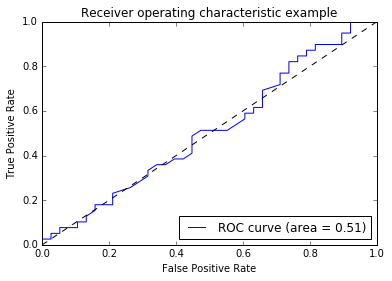

In [138]:
# Compute ROC curve and area the curve
from sklearn.metrics import roc_curve, auc
import pylab as pl

fpr, tpr, thresholds = roc_curve(Table['Actual'],Table['Predicted'])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# Plot ROC curve
pl.clf()
pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic example')
pl.legend(loc="lower right")
pl.show()

In [139]:
test[(test.Actual == 1) & (test.Predicted < 0.5)]

,index,performance,address,internet,studyTime,momEdu,dadEdu,famsup,activities,absence,sex,travelTime,romantic,Predicted,Actual


In [140]:
test[(test.Actual == 0) & (test.Predicted >= 0.5)]

,index,performance,address,internet,studyTime,momEdu,dadEdu,famsup,activities,absence,sex,travelTime,romantic,Predicted,Actual
1,23,F,T,T,F,F,F,T,T,F,T,F,F,0.6410,0
4,40,F,T,T,F,F,F,T,T,T,F,F,T,0.6585,0
5,44,F,T,T,F,F,F,F,T,T,F,F,F,0.6690,0
6,45,F,T,T,F,T,F,T,T,T,F,F,T,0.6565,0
8,53,F,T,T,F,T,T,T,F,F,F,F,F,0.6680,0
11,71,F,T,T,T,T,F,F,F,F,T,F,F,0.6190,0
13,81,F,T,T,F,F,F,T,F,F,T,F,F,0.6595,0
14,89,F,T,F,F,F,F,T,F,T,F,F,F,0.6520,0
16,103,F,T,T,F,T,T,T,T,T,T,F,F,0.6400,0
19,120,F,F,T,F,F,F,F,T,T,T,F,T,0.6720,0


# Inference evaluation

In [158]:
gibbs('performance', dict(sex=T), acad, 100)

{False: 0.47, True: 0.53}

In [159]:
gibbs('performance', dict(studytime= T), acad, 100)

{False: 0.5408333333333334, True: 0.45916666666666667}